<a href="https://colab.research.google.com/github/rupof/portafolio/blob/main/Cohort5_RobertoF_variational_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cohort 5: Task 2 Encoding and Classifier

Task requested for the Quantum Computing Mentorship Program at QOSF. 





Roberto Flórez Ablan

Federal University of São Carlos, Brazil

rflorezablan@gmail.com


Variational classifier
======================


This notebook encodes classical data using Amplitude and Angle encoding and classifies it using a variational classifier algorithm. The overall structure is based on the [Variational Classifier](https://pennylane.ai/qml/demos/tutorial_variational_classifier.html) tutorial.  




We will use a variational quantum classifier to reproduce the parity function of the given dataset.  The procedure shows how to deal with classical inputs using  amplitude and angle encoding. The amplitude encoding approach was taken following [  Möttönen, et al. (2004)](https://arxiv.org/abs/quant-ph/0407010) as done in the PENNYLANE tutorial. The angle encoding implementation used PENNYLANE ready-to-go function `qml.templates.AngleEmbedding`. For both approaches we considered completely arbitrary gate rotations connected through CNOTs.

We were able to train circuits with different number of layers and found that for the Amplitude Embedding case, circuits trained with 2 or 5 layers were the most accurate in classifying test and training data.  In the Angle Embedding approach, the 1 layer circuit obtained the best results. Moreover, we also show how the classifier algorithm for the best circuits changes as it is trained.  Further explorations changing the type of gates for the implemented circuit can be done, but time limitations did not allow these inquiries. 



1. Fitting the  function
==============================

Imports
-------



Collabs imports and installations.

In [1]:
!pip install matplotlib

In [2]:
!pip install pennylane


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import NesterovMomentumOptimizer

Amplitude encoding
===========================

We create a quantum device with two qubits (“wires”). 


In [5]:
Nqubit = 2
dev = qml.device("default.qubit", wires=Nqubit)

In our variational classifiers we define  an elementary circuit architecture that gets repeated to build the
variational circuit (layer). Our circuit layer consists of an arbitrary rotation on every qubit, as
well as CNOTs that entangle each qubit with its neighbour.


In [6]:
def layer(W):
    qml.RX(W[0,0], wires = 0)
    qml.RY(W[0,1], wires = 0)
    qml.RZ(W[0,2], wires = 0)

    qml.RX(W[1,0], wires = 1)
    qml.RY(W[1,1], wires = 1)
    qml.RZ(W[1,2], wires = 1)
    
    qml.CNOT(wires=[0, 1])

To encode our data inputs $x$ into the circuit, we follow [Mottonen, 2004](https://arxiv.org/abs/quant-ph/0407010) scheme. Our inputs have to be translated into a set of angles to acquire the correct state. The relation between the angle and inputs is given in the aforementioned paper. Moreover, considering Amplitude encoding we follow the gate implementation of the paper and obtain a general circuit to translate our initial inputs 





In [7]:
def get_angles(x):

    beta0 = 2 * np.arcsin(np.sqrt(x[1] ** 2) / np.sqrt(x[0] ** 2 + x[1] ** 2 + 1e-12))
    beta1 = 2 * np.arcsin(np.sqrt(x[3] ** 2) / np.sqrt(x[2] ** 2 + x[3] ** 2 + 1e-12))
    beta2 = 2 * np.arcsin(
        np.sqrt(x[2] ** 2 + x[3] ** 2)
        / np.sqrt(x[0] ** 2 + x[1] ** 2 + x[2] ** 2 + x[3] ** 2)
    )

    return np.array([beta2, -beta1 / 2, beta1 / 2, -beta0 / 2, beta0 / 2])


def statepreparation(a):
    qml.RY(a[0], wires=0)
    qml.CNOT(wires=[0, 1])
    qml.RY(a[1], wires=1)
    qml.CNOT(wires=[0, 1])
    
    qml.RY(a[2], wires=1)

    qml.PauliX(wires=0)
    qml.CNOT(wires=[0, 1])
    qml.RY(a[3], wires=1)
    
    qml.CNOT(wires=[0, 1])
    qml.RY(a[4], wires=1)
    qml.PauliX(wires=0)
    #return qml.state()

We define the quantum node as a state preparation routine, followed
by a repetition of the layer structure. We call the parameters `weights`.



In [8]:
@qml.qnode(dev)
def circuit(weights, data):
    statepreparation(data)
    for W in weights:
        layer(W)
    return qml.expval(qml.PauliZ(0))

We define our variational classifier in term of our circuit


In [9]:
def variational_classifier(weights, bias, x):
    return circuit(weights, x) + bias

Cost
====

We use the standard square loss to measures the distance between target labels and model predictions.


In [10]:
def square_loss(labels, predictions):
    loss = 0
    for l, p in zip(labels, predictions):
        loss = loss + (l - p) ** 2

    loss = loss / len(labels)
    return loss

To monitor how many inputs the current classifier predicted correctly,
we also define the accuracy given target labels and model predictions.


In [11]:
def accuracy(labels, predictions):

    loss = 0
    for l, p in zip(labels, predictions):
        if abs(l - p) < 1e-5:
            loss = loss + 1
    loss = loss / len(labels)

    return loss

For learning tasks, the cost depends on the data - here the features and
labels considered in the iteration of the optimization routine.


In [12]:
def cost(weights, bias, X, Y):
    predictions = [variational_classifier(weights, bias, x) for x in X]
    return square_loss(Y, predictions)

Optimization
============

Let’s now load and preprocess the training data...



In [13]:
#data = np.loadtxt("./data/mock_train_set.csv", delimiter=",") # For the local case
data = np.loadtxt("./drive/MyDrive/data/mock_train_set.csv", delimiter=",") # For the colab (google drive) case

X = np.array(data[1:, :-1], requires_grad = False)
Y = np.array(data[1:, -1], requires_grad = False)

normalization = np.sqrt(np.sum(X**2, -1))
X_norm = (X.T / normalization).T

features = np.array([get_angles(x) for x in X_norm], requires_grad=False)


Y = np.array(data[1:, -1], requires_grad = False)
Y = Y * 2 - np.ones(len(Y)) # We deal with -1,1 outputs instead of 1,0


... and test data.

In [14]:

#data = np.loadtxt("mock_test_set.csv", delimiter=",") # For the local case
data_test = np.loadtxt("./drive/MyDrive/data/mock_test_set.csv", delimiter=",") # For the colab (google drive) case

X_test = np.array(data_test[1:, :-1], requires_grad = False)
Y_test = np.array(data_test[1:, -1], requires_grad = False)

normalization_test = np.sqrt(np.sum(X_test**2, -1))
X_norm_test = (X_test.T / normalization_test).T

features_test = np.array([get_angles(x) for x in X_norm_test], requires_grad=False)

Y_test = np.array(data_test[1:, -1], requires_grad = False)
Y_test = Y_test * 2 - np.ones(len(Y_test))

Our ansatz is randomly selected. We make a function that generates new ansatz for $ N $ layers, so that we can characterize our model in terms of the number of circuit layers 


In [15]:
def weights_bias_ansatz(num_layers, num_qubits):
  np.random.seed(0)
  weights_init = 0.1 * np.random.randn(num_layers, num_qubits, 3) #Parameters to be optimized
  bias_init = np.array(0.0)
  return weights_init, bias_init

For each different circuit (different number of layers) we create a new optimizer `NesterovMomentumOptimizer` and train it. We track the accuracy - the share of correctly
classified data samples (of the training data set). For this we compute the outputs of the
variational classifier and turn them into predictions in $\{-1,1\}$ by
taking the sign of the output. Moreover, we also track the accuracy with the test data set. We track both values for models with different number of layers  



In [17]:
batch_size = 5
number_of_iterations = 25
layers_accuracy = [i for i in range(1,7)] #Circuit layers
for num_layers in range(1, len(layers_accuracy)):
  opt = NesterovMomentumOptimizer(0.5) #New optimizer
  weights, bias = weights_bias_ansatz(num_layers, Nqubit   )
  train_set_accuracy = np.zeros(number_of_iterations)
  test_set_accuracy = np.zeros(number_of_iterations)
  print(f"Training system with {num_layers} layers")
  layers_accuracy[num_layers] = accuracy

  for it in range(number_of_iterations):

      # Update the weights by one optimizer step
      batch_index = np.random.randint(0, len(features), (batch_size,))
      X_batch = features[batch_index]
      Y_batch = Y[batch_index]
    
      weights, bias, _, _ = opt.step(cost, weights, bias, X_batch, Y_batch)

      # Compute accuracy
      trained_predictions = [np.sign(variational_classifier(weights, bias, x)) for x in features]
      train_set_accuracy[it] = accuracy(Y, trained_predictions)


      test_predictions = [np.sign(variational_classifier(weights, bias, x)) for x in features_test]
      test_set_accuracy[it] = accuracy(Y_test, test_predictions)

  
  layers_accuracy[num_layers] = [train_set_accuracy, test_set_accuracy ] #We save the accuracy by iteratio of each circuit layer



      

Training system with 1 layers
Training system with 2 layers
Training system with 3 layers
Training system with 4 layers
Training system with 5 layers


Plotting accuracy results

In [18]:
import matplotlib.pyplot as plt

We find the final accuracy

In [19]:
last_train_accuracy =  [float(str(layers_accuracy[i][0][-1])) for i in range(1,6)]
last_test_accuracy =  [float(str(layers_accuracy[i][1][-1])) for i in range(1,6)]

And make a bar plot

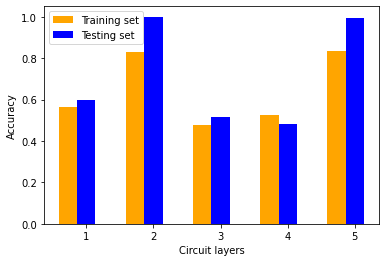

In [20]:
N = 5
ind = np.arange(N)  # the x locations for the groups
width = 0.27       # the width of the bars

fig = plt.figure()
ax = fig.add_subplot(111)

yvals = last_train_accuracy
rects1 = ax.bar(ind, yvals, width, color='orange')
zvals = last_test_accuracy
rects2 = ax.bar(ind+width, zvals, width, color='blue')


ax.set_xticks(ind+width)
ax.set_xticklabels( ('1', '2', '3', '4', "5") )

ax.set_ylabel("Accuracy")
ax.set_xlabel("Circuit layers")

ax.legend( (rects1[0], rects2[0]), ('Training set', 'Testing set') )


Circuits with 2 and 5 layers are the most accurate, classifying correctly XX% and YY% of the testing data

In [21]:
print("Training data accuracy")
print(f"2 layer circuit: {yvals[1]}, 5 layer circuit: {yvals[4]})")

print("Testing data accuracy")
print(f"2 layer circuit: {zvals[1]}, 5 layer circuit: {zvals[4]})")

Training data accuracy
2 layer circuit: 0.83, 5 layer circuit: 0.8333333333333334)
Testing data accuracy
2 layer circuit: 1.0, 5 layer circuit: 0.9916666666666667)


We can explore how these classifiers evolve for each iteration

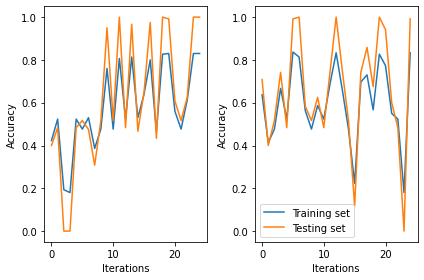

In [22]:


plt.subplot(1, 2, 1)
train_set_accuracy_best_circuit, test_set_accuracy_best_circuit  = layers_accuracy[2] 
plt.plot(range(number_of_iterations), train_set_accuracy_best_circuit, label = "Training set" )
plt.plot(range(number_of_iterations), test_set_accuracy_best_circuit, label = "Testing set" )
plt.xlabel("Iterations")
plt.ylabel("Accuracy")


plt.subplot(1, 2, 2)
train_set_accuracy_best_circuit, test_set_accuracy_best_circuit  = layers_accuracy[5] 
plt.plot(range(number_of_iterations), train_set_accuracy_best_circuit, label = "Training set" )
plt.plot(range(number_of_iterations), test_set_accuracy_best_circuit, label = "Testing set" )
plt.xlabel("Iterations")
plt.ylabel("Accuracy")

plt.tight_layout()
plt.legend()

# Angle encoding

In the case Angle encoding, we need 4 qubits, one for each input and again consider an arbitrary rotation on every qubit. 



In [23]:
Nqubit = 4  
dev = qml.device("default.qubit", wires= Nqubit)

In [24]:
def layer(W):

    qml.RX(W[0,0], wires=0)
    qml.RY(W[0,1], wires=0)
    qml.RZ(W[0,2], wires=0)

    qml.RX(W[1,0], wires=1)
    qml.RY(W[1,1], wires=1)
    qml.RZ(W[1,2], wires=1)

    qml.RX(W[2,0], wires=2)
    qml.RY(W[2,1], wires=2)
    qml.RZ(W[2,2], wires=2)
    
    qml.RX(W[3,0], wires=3)
    qml.RY(W[3,1], wires=3)
    qml.RZ(W[3,2], wires=3)
    
    qml.CNOT(wires=[0, 1])
    qml.CNOT(wires=[1, 2])
    qml.CNOT(wires=[2, 3])
    qml.CNOT(wires=[3, 0])


Our state now encodes data through Angle Embedding, we use Hadamard to create a superposition and use the built-in Angle Embedding 

In [25]:
def statepreparation(data):
    for i in range(Nqubit):
        qml.Hadamard(i)
    qml.templates.AngleEmbedding(features=data, wires=range(Nqubit),rotation='Z')

We redefine our previous functions  and data considering the new encoding and system size

In [26]:
@qml.qnode(dev)
def circuit(weights, x):

    statepreparation(x)

    for W in weights:
        layer(W)

    return qml.expval(qml.PauliZ(0))


def variational_classifier(weights, bias, x):
    return circuit(weights, x) + bias

In [27]:
features = np.array([x for x in X_norm], requires_grad=False)
features_test = np.array([x for x in X_norm_test], requires_grad=False)


And make a new ansatz

In [28]:
number_of_iterations = 25
layers_accuracy = [i for i in range(1,7)]
for num_layers in range(1, len(layers_accuracy)):
  opt = NesterovMomentumOptimizer(0.5)
  weights, bias = weights_bias_ansatz(num_layers, Nqubit)
  train_set_accuracy = np.zeros(number_of_iterations)
  test_set_accuracy = np.zeros(number_of_iterations)
  print(f"Training system with {num_layers} layers")
  layers_accuracy[num_layers] = accuracy

  for it in range(number_of_iterations):

      # Update the weights by one optimizer step
      batch_index = np.random.randint(0, len(features), (batch_size,))
      X_batch = features[batch_index]
      Y_batch = Y[batch_index]
    
      weights, bias, _, _ = opt.step(cost, weights, bias, X_batch, Y_batch)

      # Compute accuracy
      trained_predictions = [np.sign(variational_classifier(weights, bias, x)) for x in features]
      train_set_accuracy[it] = accuracy(Y, trained_predictions)


      test_predictions = [np.sign(variational_classifier(weights, bias, x)) for x in features_test]
      test_set_accuracy[it] = accuracy(Y_test, test_predictions)

  
  layers_accuracy[num_layers] = [train_set_accuracy, test_set_accuracy ]



      

Training system with 1 layers
Training system with 2 layers
Training system with 3 layers
Training system with 4 layers
Training system with 5 layers


Plotting

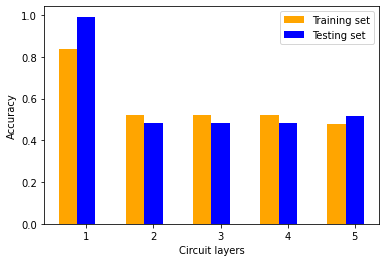

In [29]:
#Organizing results
last_train_accuracy =  [float(str(layers_accuracy[i][0][-1])) for i in range(1,6)]
last_test_accuracy =  [float(str(layers_accuracy[i][1][-1])) for i in range(1,6)]

#Plotting bars!
N = 5
ind = np.arange(N)  # the x locations for the groups
width = 0.27       # the width of the bars

fig = plt.figure()
ax = fig.add_subplot(111)

yvals = last_train_accuracy
rects1 = ax.bar(ind, yvals, width, color='orange')
zvals = last_test_accuracy
rects2 = ax.bar(ind+width, zvals, width, color='blue')


ax.set_xticks(ind+width)
ax.set_xticklabels( ('1', '2', '3', '4', "5") )

ax.set_ylabel("Accuracy")
ax.set_xlabel("Circuit layers")

ax.legend( (rects1[0], rects2[0]), ('Training set', 'Testing set') )


The circuit with 1 layer is the most accurate!

In [30]:
print("Training data accuracy")
print(f"1 layer circuit: {yvals[0]}")

print("Testing data accuracy")
print(f"1 layer circuit: {zvals[0]}")

Training data accuracy
1 layer circuit: 0.8366666666666667
Testing data accuracy
1 layer circuit: 0.9916666666666667


Let's see how it reaches that accuracy

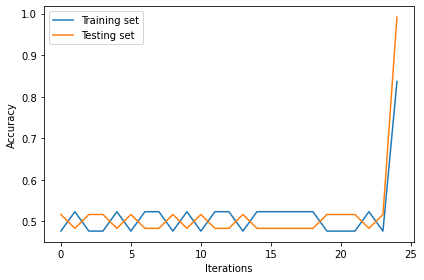

In [31]:
train_set_accuracy_best_circuit, test_set_accuracy_best_circuit  = layers_accuracy[1] 
plt.plot(range(number_of_iterations), train_set_accuracy_best_circuit, label = "Training set" )
plt.plot(range(number_of_iterations), test_set_accuracy_best_circuit, label = "Testing set" )


plt.xlabel("Iterations")
plt.ylabel("Accuracy")
plt.tight_layout()
plt.legend()